# DLA simulation

---

In this notebook I am simulating [diffusion limited aggregation](https://en.wikipedia.org/wiki/Diffusion-limited_aggregation), and calculate the objects fractal dimension, and multifractal spectrum and plot some interactive plots about the growing cluster and the attachment of particles to the cluster.


### Description of the simulation

Steps:

- start with an aggregate made of one point.
- release particles randomly on a circle outside the bounding box of the aggregate.
- simluate Brownian motion until the particle reaches the aggregate, or it goes outside a larger circle.

I decided to implement the aggregate as a dictionary. The keys are the coordinates, and the values show the indices of the particles (temporal order). I find it more intuitive and flexibe than storing a grid.

The expected aggregate should looks something like this:

![diff](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3d/Of7_p0001_15h.jpg/538px-Of7_p0001_15h.jpg)

### Calculating the objects  fractal dimension

I calculate the objects fractal dimension using the [Correlation dimension](https://en.wikipedia.org/wiki/Correlation_dimension). The expected result is $D=1.71$ .


### Calculating the objects multifractal spectrum

Simply using the definition, and multiple pivot points. The distances are running from 20 to 40. This represents a lower cutoff 20x larger than particle size, and around 20x smaller than the size of the aggregate. Vicsek et al uses 100x cutting at the edges, I don't have that large aggregate.

The expected aggregate looks like this ( from Vicsek et al ):

![diff](dq_vicsek.png)

References

* Vicsek, T., F. Family, and P. Meakin. "Multifractal geometry of diffusion-limited aggregates." EPL (Europhysics Letters) 12.3 (1990): 217.

---

*Author: Dezso Ribli*

In [1]:
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.spatial
import numpy as np
import pickle
from ipywidgets import interact,fixed

# my own fucntions
from grow import grow,seed_circle,walk

%matplotlib inline

### Functions only used in the notebook are defined here:

In [2]:
def aggplot(agg,N,ms=10):
    """Plot aggragate after N particles added."""
    # get x,y points in the order they were added!
    x,y = zip(*sorted(agg, key=agg.get)) 
    plt.figure(figsize=(9,9)) # square plot
    plt.plot(x[:N],y[:N],'.',ms=ms)
    plt.xlim(min(x),max(x)) # fix size for better interactivity
    plt.ylim(min(y),max(y))
    plt.axis('off')
    plt.show() # somehow needed (?), its a workaround
    
    
def attach(agg):
    """Try to attach particles until succesful."""
    while True:
        oldlen=len(agg)
        newagg,route=walk(agg)
        if len(newagg) > oldlen:
            return newagg,route
            

def attachplot(agg,route,N=2,ms=10,lw=1):
    """Plot route of particle until it attaches to aggregate."""
    # get x,y points in the order they were added!
    x,y = zip(*sorted(agg, key=agg.get))
    rx,ry = zip(*route)  # get route points
    plt.figure(figsize=(9,9)) # square plot
    plt.plot(x,y,'.',ms=ms)
    plt.xlim(min(x+rx),max(x+rx)) # fix size for better interactivity
    plt.ylim(min(y+ry),max(y+ry))
    
    plt.plot(rx[:N],ry[:N],lw=lw)
    plt.axis('off')
    plt.show() # somehow needed (?), its a workaround
    
    
def corr_dim(agg,cut=5,plot=True):
    """Return and (plot) correlation dimension."""
    x,y = zip(*agg) # get x,y points 
    xy = np.column_stack((np.array(x),np.array(y))) # pack them
    dl = scipy.spatial.distance.pdist(xy) # get all pairwise dist
    
    dl = dl[dl<seed_circle(agg)[1]/cut] # limit for the size of agg/L
    r = np.log10(np.sort(dl)) # log dist
    c = np.log10(np.arange(1,len(r)+1)) # log number of dist under r
    
    #lower limit a
    rf=r[r>np.log10(cut)]
    cf=c[r>np.log10(cut)]

    # fit linear on log log
    (a,b),pcov = scipy.optimize.curve_fit(lambda x,a,b: a*x+b,rf,cf)

    r = r[::len(r)/int(1e4)]  # do not plot all points
    c = c[::len(c)/int(1e4)]
    
    if plot: #plot it if asked for
        plt.figure(figsize=(9,6))
        plt.plot(r,c,'x')
        lab = 'coef = '+ "%.2f +/- %.2f"% (a, pcov[0,0]**0.5)
        plt.plot(r, a*r+b, label=lab)
        plt.xlabel('log10(r)',fontsize=16)
        plt.ylabel('log10(N(<r))',fontsize=16)
        plt.ylim(2) # lot of small dists, do not show them
        plt.legend(fontsize=16)
        plt.grid()
    return a

### Create a small aggregate

In [3]:
%%time
N = 3000
agg = grow(npart=N) # create the aggregate
print 'Out of ',N,' particles, ', len(agg), 'landed in the aggregate'

Out of  3000  particles,  1115 landed in the aggregate
CPU times: user 3.74 s, sys: 47.4 ms, total: 3.79 s
Wall time: 3.78 s


### Plot it

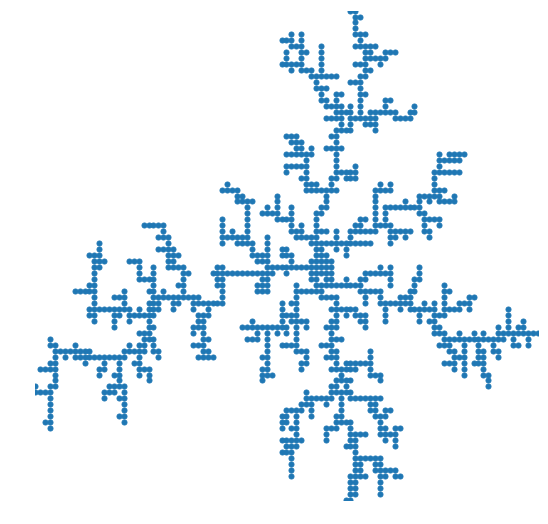

In [4]:
# interactive plot for growing agg
_=interact(aggplot,agg=fixed(agg),N=(0,len(agg),1),ms=fixed(10)) 

### Attach one more particle

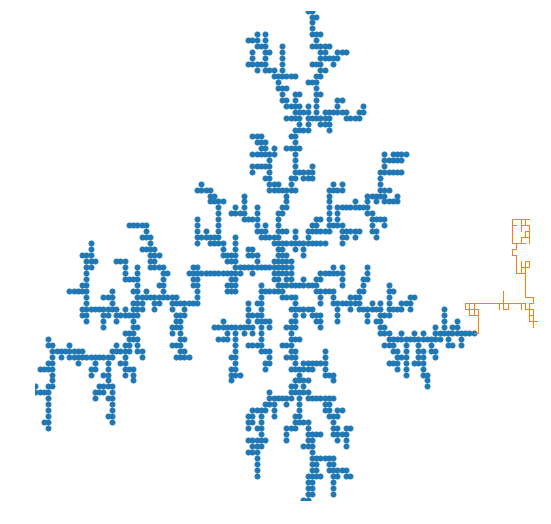

In [5]:
newagg,route = attach(agg)  # attach one particle
        
# interactive plot for attaching
_=interact(attachplot,agg=fixed(agg),route=fixed(route),
           N=(0,len(route),1),ms=fixed(10), lw=fixed(1)) 

### Load a larger one

It is not in the notebook, because creating  a large aggregate takes time.

In [6]:
%%bash
# ./grow.py  # create it in a scipt, its slow

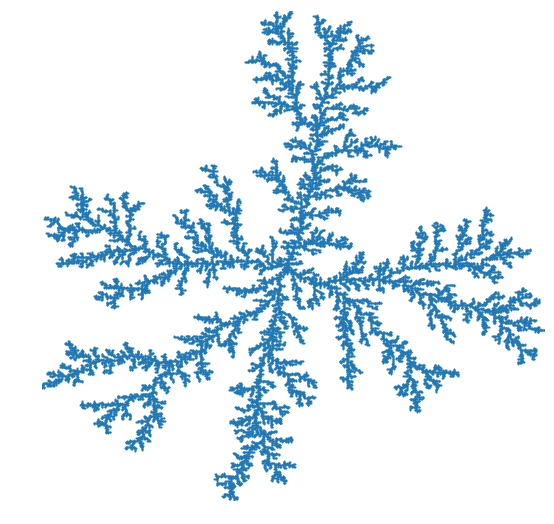

In [7]:
agg = pickle.load(open('agg.pkl','rb'))  # load larger aggregate

# interactive plot for growing agg
_=interact(aggplot,agg=fixed(agg),N=(0,len(agg),1),ms=fixed(2)) 

### Attach to this one too

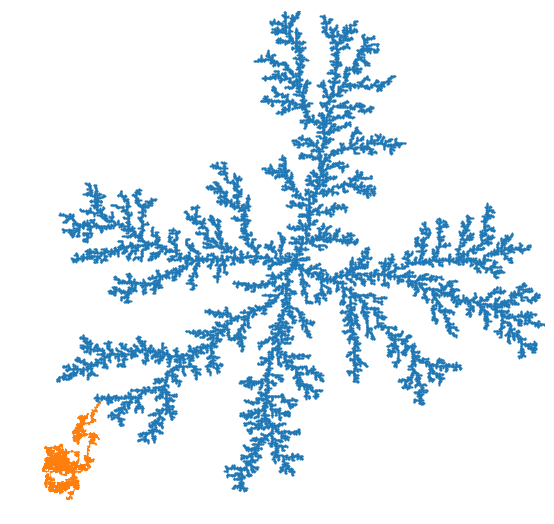

In [8]:
newagg,route = attach(agg)  # attach one particle
        
# interactive plot for attaching
_=interact(attachplot,agg=fixed(agg),route=fixed(route),
           N=(0,len(route),1),ms=fixed(2), lw=fixed(1)) 

---

## Calculate correlation dimension



CPU times: user 4.25 s, sys: 2.84 s, total: 7.09 s
Wall time: 7.85 s


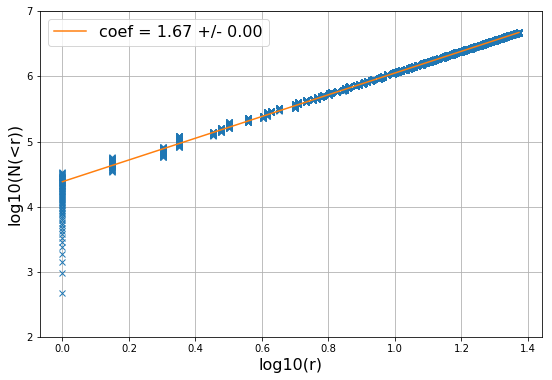

In [9]:
%%time
_=corr_dim(agg, cut=20)  # cut controls the ignored edges of the distribution

---


## Plot multifractal spectrum


This is slow too, not done in the notebook.


In [10]:
%%bash
# ./dq.py  # calculate multifractal spectrum

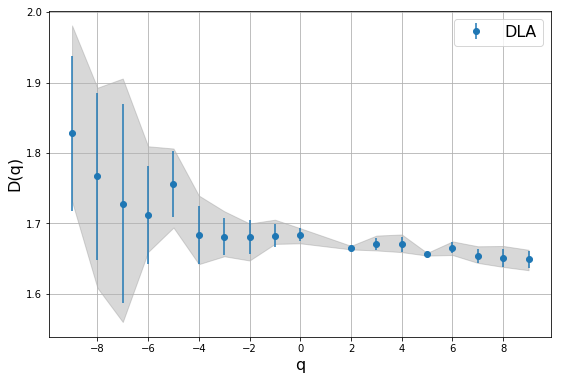

In [11]:
q, Dq = pickle.load(open('Dq.pkl','rb'))
plt.figure(figsize=(9,6))
plt.errorbar(q,np.mean(Dq,axis=0),np.std(Dq,axis=0),fmt='o',label='DLA')
plt.fill_between(q,np.min(Dq,axis=0),np.max(Dq,axis=0),color='gray',alpha=0.3)
plt.grid()
plt.xticks(range(-8,10,2))
plt.legend(fontsize=16)
plt.xlabel('q',fontsize=16)
_=plt.ylabel('D(q)',fontsize=16)

---

## Discussion

* The simluated aggregate looks right
* The calculated dimension is a bit lower than 1.71, probably the aggregate is too small, and the edges effect the result.
* The D(q) curve is quite similar to the one in the literature. The fractal dimension is still consistently lower than 1.71. 
    * The shape of the D(q) curve is very sensitive to the range or r-s examined. 
        * Too small r-s lead to strangely low D(q) when q is negative
        * Also experienced a valley around 0, when the upper limit of r was too high